In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn

# Load your dataset
df = pd.read_csv("movies_metadata.csv")

C:\Users\rizhi\AppData\Local\Temp\ipykernel_27252\2809421590.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("movies_metadata.csv")


In [110]:
import json
#generate unique
genresCol = df['genres']

uniqueGenres = set()

for genre in genresCol:
    jsonString = str(genre).replace("'", '"')
    genreObj = json.loads(jsonString)
    for g in genreObj:
        uniqueGenres.add(g['name'])
print(uniqueGenres)
print(len(uniqueGenres))

{'Mardock Scramble Production Committee', 'Sentai Filmworks', 'Family', 'Drama', 'Thriller', 'Documentary', 'Carousel Productions', 'History', 'Telescene Film Group Productions', 'Western', 'Romance', 'Pulser Productions', 'Vision View Entertainment', 'Foreign', 'Odyssey Media', 'Science Fiction', 'Horror', 'Fantasy', 'GoHands', 'Comedy', 'Action', 'The Cartel', 'BROSTA TV', 'Rogue State', 'Music', 'Crime', 'Adventure', 'TV Movie', 'Animation', 'Mystery', 'War', 'Aniplex'}
32


In [111]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
if torch.cuda.is_available():
    model.cuda()

In [112]:
def title_to_embedding(title, counter):
    inputs = tokenizer(title, return_tensors="pt")
    if torch.cuda.is_available():
        inputs.to('cuda')
    outputs = model(**inputs)
    if counter['counter'] % 100 == 0:
        print(counter['counter'])
    counter['counter'] += 1
    return outputs.last_hidden_state.mean(dim=1).cpu().detach().numpy()

In [5]:
counterObj = {'counter': 0}
df['embeddings'] = df['original_title'].apply(title_to_embedding, counter=counterObj)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [6]:
# save dataframe with titles, genres, and embeddings only
df[['original_title', 'genres', 'embeddings']].to_csv("movies_metadata_embeddings.csv")

In [8]:
df['embeddings'][0].shape

(1, 768)

In [86]:
# there are 768 features in each embedding
# Neural Network Model
class GenrePredictionModel(nn.Module):
    def __init__(self, input_size, num_genres):
        super(GenrePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 768)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(768, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_genres)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        #x = self.softmax(x)
        return x


#genres
genresArray = []
for genre in df['genres']:
    jsonString = str(genre).replace("'", '"')
    genreObj = json.loads(jsonString)
    genresArray.append([])
    for g in genreObj:
        genresArray[-1].append(g['name'])
        

# Data Splitting
embeddingsList = list(map(lambda x: x[0], df['embeddings']))
X_train, X_test, y_train, y_test = train_test_split(embeddingsList, genresArray, test_size=0.2)
input_size = len(X_train[0])
print(input_size)

768


(1, 768)

In [87]:
import torch.optim as optim
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(genresArray)
X = torch.tensor(np.stack(embeddingsList), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

input_size = X.shape[1]
print(input_size)
num_genres = len(uniqueGenres)
model = GenrePredictionModel(input_size, num_genres)

criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

768


In [88]:
num_epochs = 100
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 700 == 0:  # Print every 10th batch of an epoch
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

print("Training Complete")

Epoch [1/100], Step [700/1421], Loss: 0.14459766447544098
Epoch [1/100], Step [1400/1421], Loss: 0.15221039950847626
Epoch [2/100], Step [700/1421], Loss: 0.15700869262218475
Epoch [2/100], Step [1400/1421], Loss: 0.151848703622818
Epoch [3/100], Step [700/1421], Loss: 0.16218417882919312
Epoch [3/100], Step [1400/1421], Loss: 0.1346132904291153
Epoch [4/100], Step [700/1421], Loss: 0.17199964821338654
Epoch [4/100], Step [1400/1421], Loss: 0.1558416783809662
Epoch [5/100], Step [700/1421], Loss: 0.14694063365459442
Epoch [5/100], Step [1400/1421], Loss: 0.14752505719661713
Epoch [6/100], Step [700/1421], Loss: 0.147489994764328
Epoch [6/100], Step [1400/1421], Loss: 0.15057452023029327
Epoch [7/100], Step [700/1421], Loss: 0.13062968850135803
Epoch [7/100], Step [1400/1421], Loss: 0.13392210006713867
Epoch [8/100], Step [700/1421], Loss: 0.10662250965833664
Epoch [8/100], Step [1400/1421], Loss: 0.15143698453903198
Epoch [9/100], Step [700/1421], Loss: 0.13130027055740356
Epoch [9/100

In [94]:
print(df['original_title'][2])
print(df['genres'][2])

Grumpier Old Men
[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]


In [100]:
# save model
torch.save(model.state_dict(), "model.pt")

In [107]:
model.eval()
totalScore = 0
with torch.no_grad():
    for i in range(len(X_test)):
        inputs = torch.tensor([X_test[i]], dtype=torch.float32)
        outputs = model(inputs)
        predicted = outputs > 0
        score = 0
        actual = y_test[i]
        for i in range(len(predicted[0])):
            if predicted[0][i]:
                #print(mlb.classes_[i])
                if mlb.classes_[i] in actual:
                    score += 1
        if len(actual) > 0:
            totalScore += score / len(actual)
print("Average Score: ", totalScore / len(X_test))
    #predicted = predicted.numpy()
    #actual_genres = mlb.inverse_transform(np.ndarray(embeddingsList[0]))
    #predicted_genres = mlb.inverse_transform(predicted)
    #print("Predicted Genres: ", predicted_genres[0])
    #print("Actual Genres: ", actual_genres[0])

Average Score:  0.887289107417766


In [135]:
# testing with some movie titles
# load model
cmodel = GenrePredictionModel(input_size, num_genres)
cmodel.load_state_dict(torch.load("model.pt"))

title = "star wars"
embeddings = title_to_embedding(title, {'counter': 0})
inputs = torch.tensor(embeddings)
outputs = cmodel(inputs)
predicted = outputs > 0
score = 0
actual = y_test[i]
for i in range(len(predicted[0])):
    if predicted[0][i]:
        print(mlb.classes_[i])


0
Action
Adventure
Science Fiction


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31],
 [Text(0, 0, 'Animation'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Family'),
  Text(3, 0, 'Adventure'),
  Text(4, 0, 'Fantasy'),
  Text(5, 0, 'Romance'),
  Text(6, 0, 'Drama'),
  Text(7, 0, 'Action'),
  Text(8, 0, 'Crime'),
  Text(9, 0, 'Thriller'),
  Text(10, 0, 'Horror'),
  Text(11, 0, 'History'),
  Text(12, 0, 'Science Fiction'),
  Text(13, 0, 'Mystery'),
  Text(14, 0, 'War'),
  Text(15, 0, 'Foreign'),
  Text(16, 0, 'Music'),
  Text(17, 0, 'Documentary'),
  Text(18, 0, 'Western'),
  Text(19, 0, 'TV Movie'),
  Text(20, 0, 'Carousel Productions'),
  Text(21, 0, 'Vision View Entertainment'),
  Text(22, 0, 'Telescene Film Group Productions'),
  Text(23, 0, 'Aniplex'),
  Text(24, 0, 'GoHands'),
  Text(25, 0, 'BROSTA TV'),
  Text(26, 0, 'Mardock Scramble Production Committee'),
  Text(27, 0, 'Sentai Filmworks')

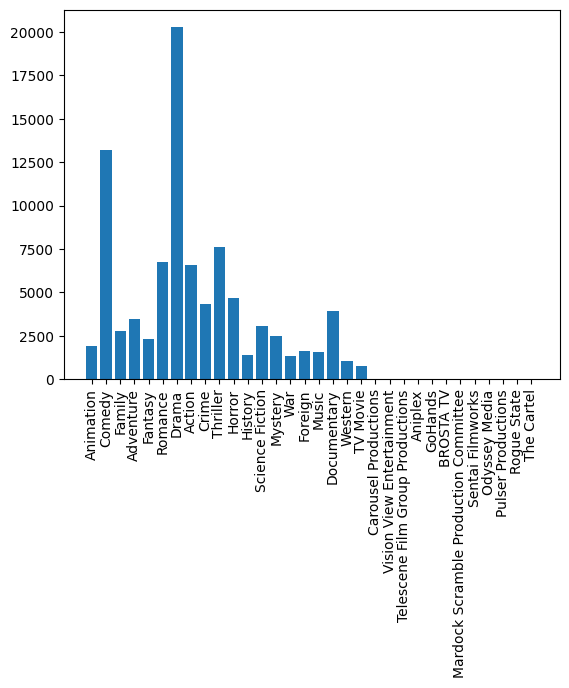

In [138]:
# analysing genre distribution
genresammounts = {}

for movie in genresArray:
    for genre in movie:
        if genre in genresammounts:
            genresammounts[genre] += 1
        else:
            genresammounts[genre] = 1

# build bar chart of genre distribution
import matplotlib.pyplot as plt

plt.bar(genresammounts.keys(), genresammounts.values())
plt.xticks(rotation=90)